In [1]:
import time
import math
import copy
import torch
import pickle
import random
import logging
import warnings
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import fairlearn.datasets
from tqdm import tqdm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from torch.autograd import grad
from torch.autograd.functional import vhp
from get_datasets import get_adult
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score
from scipy.stats import spearmanr

plt.rcParams['figure.dpi'] = 300
warnings.filterwarnings("ignore")

E = math.e

### Utility Functions

In [19]:
def visualize_result(e_k_actual, e_k_estimated, ep, k_):

    #e_k_estimated = [-1*ek for ek in e_k_estimated]
    fig, ax = plt.subplots()
    palette = sns.color_palette("cool", len(e_k_actual))
    sns.set(font_scale=1.15)
    sns.set_style(style='white')
    min_x = np.min(e_k_actual)
    max_x = np.max(e_k_actual)
    min_y = np.min(e_k_estimated)
    max_y = np.max(e_k_estimated)
    
    plt.rcParams['figure.figsize'] = 6, 5
    z = np.polyfit(e_k_actual,  e_k_estimated, 1)
    p = np.poly1d(z)
    xx = np.linspace(-p(2)/p(1), max(e_k_actual)+.0001)
    yy = np.polyval(p, xx)
    #add trendline to plot
    ax.plot(xx, yy, ls="-", color='k')
    for k in range(len(e_k_actual)):
        ax.scatter(e_k_actual[k], e_k_estimated[k], zorder=2, s=45, color = palette[k], label=ep[k])

    ax.set_title(f'Actual vs. Estimated loss for k={k_:.2f}%')
    ax.set_xlabel('Actual loss difference')
    ax.set_ylabel('Estimated loss difference')
   
    ax.set_xlim(min_x-.0001, max_x+.0001)
    ax.set_ylim(min_y-.0001, max_y+.0001)
    
   
    text = 'MAE = {:.03}\nP = {:.03}'.format(mean_absolute_error(e_k_actual, e_k_estimated), spearmanr(e_k_actual, e_k_estimated).correlation)
    ax.text(max_x+.00009,min_y-.00008, text, verticalalignment='bottom', horizontalalignment='right')
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.tight_layout()
    plt.xticks(rotation = 45)
    plt.show()
    # cooler color = smaller epsilon

In [3]:
 class CreateData(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.targets[idx]

        return out_data, out_label

In [4]:
def get_data(new_train_df, feature_set, label, k):    

    selected_group = new_train_df.loc[new_train_df['sex'] == 0]

    num_to_sample = round((k / 100)*len(selected_group))

    sampled_group = selected_group.sample(n=num_to_sample)
    not_selected = new_train_df.drop(sampled_group.index)

    selected_group_X = sampled_group[feature_set]
    selected_group_y = sampled_group[label]

    not_selected_group_X = not_selected[feature_set]
    not_selected_group_y = not_selected[label]   
    
    return selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y

### Randomized Response

In [5]:
def get_p(epsilon):
    probability = float(E ** epsilon) / float(1 + (E ** epsilon))
    p = torch.FloatTensor([[probability, 1-probability], [1-probability, probability]])
    
    return p

### Models

In [6]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        
        self.fc1 = torch.nn.Linear(num_features, 1, bias=False)
        self.criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
        
    def forward(self, x):
        logits = self.fc1(x)

        return logits
    
    def loss(self, logits, y, print_):
        loss = self.criterion(logits.ravel(), y)
        
        probabilities = torch.sigmoid(logits)
        thresh_results = []
        
        for p in probabilities:
            if p>.5:
                thresh_results.append(1)
            else:
                thresh_results.append(0)
                
        num_correct = 0
        for r,y_ in zip(thresh_results, y):
            if r == y_:
                num_correct += 1
                
        acc = num_correct / len(y)
        
        if print_:
            print("Accuracy is {0:.3f}".format(acc*100))
            print("Precision is {0:.3f}".format(precision_score(y.detach().cpu().numpy(), thresh_results, zero_division=0)))
            print("Recall is {0:.3f}".format(recall_score(y.detach().cpu().numpy(), thresh_results)))
        return loss, acc

In [7]:
def train(model, dataset):
    model.train()
    
    opt = torch.optim.SGD(model.parameters(), lr=.001, weight_decay=0)
    
    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
      
    train_data = CreateData(dataset[0], dataset[1])
    train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

    for itr in range(0, 7):
        itr_loss = 0
        for i, [x,y] in enumerate(train_dataloader):
            opt.zero_grad()
            oupt = model(x)
            
            try:
                loss_val = criterion(oupt.ravel(), y)
            except ValueError:
                loss_val = criterion(oupt, y)
            itr_loss += loss_val
            loss_val.backward()
            opt.step() 
       
    return model

### Influence Calculation Functions


In [8]:
def calc_influence_single(model, epsilon, train_data, test_data, group_data, device, num_features, criterion):
    start = time.time()
    est_hess = explicit_hess(model, train_data, device, criterion)

    grad_test = grad_z([test_data[0], test_data[1]], model, device, criterion)
    s_test_vec = torch.mm(grad_test[0], est_hess.to(device))

    P = get_p(epsilon)
    
    p_01, p_10 = P[0][1].item(), P[1][0].item()
    
    pi_1 = sum(list(group_data[1]))
    pi_0 = len(group_data[1]) - pi_1
    
    lam_0 = round(p_01 * pi_1)
    lam_1 = round(p_10 * pi_0)

    S_pert = 1 - group_data[1]
    
    y_w_group_pert = pd.concat([group_data[3], S_pert], axis = 0, ignore_index=True)
    y_wo_pert = pd.concat([group_data[3], group_data[1]], axis = 0, ignore_index=True)
    reconstructed_x = pd.concat([group_data[2], group_data[0]], axis = 0, ignore_index=True)
  
    assert len(S_pert) == len(group_data[1])
    grad_z_vec = grad_training([group_data[0],group_data[1]], S_pert, [model], device, [lam_0, lam_1, epsilon], criterion)
    
    influence = torch.dot(s_test_vec.flatten(), grad_z_vec[0].flatten()) * (1/len(train_data[0]))
    end = time.time() - start

    return influence.cpu(), end

In [9]:
def explicit_hess(model, train_data, device, criterion):
 
    logits = model(train_data[0])
    loss = criterion(logits.ravel(), train_data[1]) #reduction mean
    
    grads = grad(loss, model.parameters(), retain_graph=True, create_graph=True)

    hess_params = torch.zeros(len(model.fc1.weight[0]), len(model.fc1.weight[0]))
    
    for i in range(len(model.fc1.weight[0])):
        hess_params_ = grad(grads[0][0][i], model.parameters(), retain_graph=True)[0][0]
        for j, hp in enumerate(hess_params_):
            hess_params[i,j] = hp

            
    inv_hess = torch.linalg.inv(hess_params)
    return inv_hess

In [10]:
def grad_z(test_data, model, device, criterion):

    model.eval()

    test_data_features = test_data[0]
    test_data_labels = test_data[1]

    logits = model(test_data_features)
    loss = criterion(logits, torch.atleast_2d(test_data_labels).T) # reduction mean
    
    return grad(loss, model.parameters())

In [11]:
def grad_training(train_data, y_perts, parameters, device, epsilon, criterion):
    
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
    
    lam_0, lam_1, ep = epsilon
    lam = lam_0 + lam_1
    len_s = len(y_perts)
    
    train_data_features = torch.FloatTensor(train_data[0].values).to(device)
    train_data_labels = torch.FloatTensor(train_data[1].values).to(device)
    train_pert_data_labels = torch.FloatTensor(y_perts.values).to(device)
    
    model = parameters[0]
    model.eval()

    logits = model(train_data_features)

    orig_loss = criterion(logits, torch.atleast_2d(train_data_labels).T)
    pert_loss = criterion(logits, torch.atleast_2d(train_pert_data_labels).T)
    loss = float(1/(1 + (E ** ep)))*(pert_loss - orig_loss)
    
    to_return = grad(loss, model.parameters())
    
        
    return to_return

### Main Function

In [12]:
def Main(dataset, epsilons, ks, num_rounds):

    device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
    
    all_orig_loss_e_k = []
    all_est_loss_e_k = []
    all_time = []
    
    for nr in range(num_rounds):
        print(f'\nRound {nr+1}')
        ############
        # Get data #
        ############
        print('\nGetting Data...')
        if dataset == 'adult':
            data = get_adult()
            label = 'income_class'
        elif dataset == 'diabetes':
            data = get_diabetes()
            label = 'readmit_binary'
        else:
            data = get_law()
            label = 'admit'

        feature_set = set(data.columns) - {label}
        num_features = len(feature_set)
            
        X = data[feature_set]
        y = data[label]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
       
        new_train_df = pd.concat([X_train, y_train], axis=1)
  
        train_sample_num = len(X_train)
    
        x_test_input = torch.FloatTensor(X_test.values).to(device)
        y_test_input = torch.FloatTensor(y_test.values).to(device)

        x_train_input = torch.FloatTensor(X_train.values).to(device)
        y_train_input = torch.FloatTensor(y_train.values).to(device)
   
        ##############################################
        # Train original model and get original loss #
        ##############################################
        print('Training original model...')
        torch_model = LogisticRegression(num_features)
        torch.save(torch_model.state_dict(), 'initial_config.pth')
        torch_model.to(device)
        torch_model = train(torch_model, [x_train_input, y_train_input])
        test_loss_ori, acc_ori = torch_model.loss(torch_model(x_test_input), y_test_input, True)

        e_k_act_losses = []
        e_k_est_losses = []
        influence_time = []
        
        ################################################################
        # Perform influence and retraining for all epsilons a k values #
        ################################################################
        print('\nBegining epsilon and k rounds')
        print('-----------------------------')
        for ep in epsilons:
            print(f'\nEpsilon: {ep}')
            
            k_act_losses = []
            k_est_losses = []
            inf_time = []
            
            for k in ks:
                # Influence
                print(f'k: {k:.2f}')
                selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y = get_data(new_train_df, feature_set, label, k)
                loss_diff_approx, tot_time = calc_influence_single(torch_model, ep, [x_train_input, y_train_input], [x_test_input, y_test_input], [selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y], device, num_features, criterion)
                loss_diff_approx = -torch.FloatTensor(loss_diff_approx).cpu().numpy()
                print(f'Approx difference: {loss_diff_approx:.5f}')
                # Retrain
                P = get_p(ep)

                p_01, p_10 = P[0][1].item(), P[1][0].item()

                pi_1 = sum(list(selected_group_y))
                pi_0 = len(selected_group_y) - pi_1

                lam_0 = round(p_01 * pi_1)
                lam_1 = round(p_10 * pi_0)

                S = pd.concat([selected_group_X, selected_group_y], axis=1, ignore_index=False)

                G0 = S[label][S[label].eq(1)].sample(lam_0).index
                G1 = S[label][S[label].eq(0)].sample(lam_1).index

                G = S.loc[G0.union(G1)]
                not_g = S.drop(G0.union(G1))

                G_pert = 1 - G[label]

                y_w_group_pert = pd.concat([not_selected_group_y, not_g[label], G_pert], axis = 0, ignore_index=True)
                y_wo_pert = pd.concat([not_selected_group_y, not_g[label], G[label]], axis = 0, ignore_index=True)
                reconstructed_x = pd.concat([not_selected_group_X, not_g[feature_set], G[feature_set]], axis = 0, ignore_index=True)

                model_pert = LogisticRegression(num_features)
                model_pert.load_state_dict(torch.load('initial_config.pth'))
                model_pert.to(device)
                model_pert = train(model_pert, [torch.FloatTensor(reconstructed_x.values).to(device), torch.FloatTensor(y_w_group_pert.values).to(device)])
                test_loss_retrain, acc_retrain = model_pert.loss(model_pert(x_test_input), y_test_input, False)

                 # get true loss diff
                loss_diff_true = (test_loss_retrain - test_loss_ori).detach().cpu().item()
                print(f'True difference: {loss_diff_true:.5f}')
                k_act_losses.append(loss_diff_true)
                k_est_losses.append(loss_diff_approx)
                inf_time.append(tot_time)
            
            e_k_act_losses.append(k_act_losses)
            e_k_est_losses.append(k_est_losses)
            influence_time.append(inf_time)
            
        all_orig_loss_e_k.append(e_k_act_losses)
        all_est_loss_e_k.append(e_k_est_losses) 
        all_time.append(influence_time)
    
    return all_orig_loss_e_k, all_est_loss_e_k, all_time

### Perform Experiment 

#### Constants

In [13]:
epsilons = [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
k = np.linspace(1, 25, 10)
rounds = 3

In [14]:
all_orig_loss_e_k, all_est_loss_e_k, all_time = Main('adult', epsilons, k, rounds)

with open('all_orig_loss_e_k_adult.txt', "wb") as file:   #Pickling
    pickle.dump(all_orig_loss_e_k, file)

with open('all_est_loss_e_k_adult.txt', "wb") as file2:   #Pickling
    pickle.dump(all_est_loss_e_k, file2)


Round 1

Getting Data...
Training original model...
Accuracy is 79.600
Precision is 0.754
Recall is 0.296

Begining epsilon and k rounds
-----------------------------

Epsilon: 0.01
k: 1.00
Approx difference: 0.00232
True difference: 0.00069
k: 3.67
Approx difference: 0.00842
True difference: 0.00203
k: 6.33
Approx difference: 0.01601
True difference: 0.00370
k: 9.00
Approx difference: 0.02071
True difference: 0.00518
k: 11.67
Approx difference: 0.02625
True difference: 0.00672
k: 14.33
Approx difference: 0.03576
True difference: 0.00871
k: 17.00
Approx difference: 0.04017
True difference: 0.01019
k: 19.67
Approx difference: 0.04483
True difference: 0.01174
k: 22.33
Approx difference: 0.05240
True difference: 0.01407
k: 25.00
Approx difference: 0.06028
True difference: 0.01616

Epsilon: 0.02
k: 1.00
Approx difference: 0.00271
True difference: 0.00054
k: 3.67
Approx difference: 0.00841
True difference: 0.00185
k: 6.33
Approx difference: 0.01479
True difference: 0.00367
k: 9.00
Approx d

True difference: 0.01253

Epsilon: 0.5
k: 1.00
Approx difference: 0.00175
True difference: 0.00039
k: 3.67
Approx difference: 0.00626
True difference: 0.00150
k: 6.33
Approx difference: 0.01228
True difference: 0.00283
k: 9.00
Approx difference: 0.01563
True difference: 0.00377
k: 11.67
Approx difference: 0.02050
True difference: 0.00504
k: 14.33
Approx difference: 0.02518
True difference: 0.00648
k: 17.00
Approx difference: 0.03048
True difference: 0.00748
k: 19.67
Approx difference: 0.03459
True difference: 0.00913
k: 22.33
Approx difference: 0.04073
True difference: 0.01060
k: 25.00
Approx difference: 0.04544
True difference: 0.01198

Epsilon: 0.6
k: 1.00
Approx difference: 0.00155
True difference: 0.00037
k: 3.67
Approx difference: 0.00644
True difference: 0.00139
k: 6.33
Approx difference: 0.01034
True difference: 0.00239
k: 9.00
Approx difference: 0.01540
True difference: 0.00390
k: 11.67
Approx difference: 0.01949
True difference: 0.00494
k: 14.33
Approx difference: 0.02415
True

True difference: -0.00002
k: 6.33
Approx difference: 0.00000
True difference: -0.00004
k: 9.00
Approx difference: 0.00001
True difference: -0.00003
k: 11.67
Approx difference: 0.00001
True difference: -0.00001
k: 14.33
Approx difference: 0.00001
True difference: -0.00004
k: 17.00
Approx difference: 0.00001
True difference: -0.00004
k: 19.67
Approx difference: 0.00001
True difference: 0.00000
k: 22.33
Approx difference: 0.00001
True difference: -0.00001
k: 25.00
Approx difference: 0.00001
True difference: -0.00002

Epsilon: 10
k: 1.00
Approx difference: 0.00000
True difference: -0.00002
k: 3.67
Approx difference: 0.00000
True difference: -0.00003
k: 6.33
Approx difference: 0.00000
True difference: -0.00002
k: 9.00
Approx difference: 0.00000
True difference: -0.00002
k: 11.67
Approx difference: 0.00000
True difference: -0.00004
k: 14.33
Approx difference: 0.00000
True difference: -0.00002
k: 17.00
Approx difference: 0.00000
True difference: -0.00002
k: 19.67
Approx difference: 0.00000
Tr

True difference: 0.00050
k: 3.67
Approx difference: 0.07244
True difference: 0.00165
k: 6.33
Approx difference: 0.10296
True difference: 0.00309
k: 9.00
Approx difference: 0.13403
True difference: 0.00434
k: 11.67
Approx difference: 0.20470
True difference: 0.00559
k: 14.33
Approx difference: 0.25091
True difference: 0.00722
k: 17.00
Approx difference: 0.28697
True difference: 0.00865
k: 19.67
Approx difference: 0.31090
True difference: 0.01002
k: 22.33
Approx difference: 0.36460
True difference: 0.01178
k: 25.00
Approx difference: 0.41575
True difference: 0.01332

Epsilon: 0.4
k: 1.00
Approx difference: 0.01645
True difference: 0.00044
k: 3.67
Approx difference: 0.06463
True difference: 0.00168
k: 6.33
Approx difference: 0.11753
True difference: 0.00288
k: 9.00
Approx difference: 0.14418
True difference: 0.00420
k: 11.67
Approx difference: 0.18065
True difference: 0.00497
k: 14.33
Approx difference: 0.22641
True difference: 0.00652
k: 17.00
Approx difference: 0.28606
True difference: 

True difference: -0.00003
k: 11.67
Approx difference: 0.00040
True difference: 0.00001
k: 14.33
Approx difference: 0.00052
True difference: 0.00003
k: 17.00
Approx difference: 0.00061
True difference: -0.00000
k: 19.67
Approx difference: 0.00073
True difference: 0.00001
k: 22.33
Approx difference: 0.00084
True difference: 0.00002
k: 25.00
Approx difference: 0.00087
True difference: 0.00003

Epsilon: 8
k: 1.00
Approx difference: 0.00002
True difference: 0.00001
k: 3.67
Approx difference: 0.00004
True difference: 0.00002
k: 6.33
Approx difference: 0.00009
True difference: 0.00002
k: 9.00
Approx difference: 0.00013
True difference: -0.00001
k: 11.67
Approx difference: 0.00015
True difference: -0.00001
k: 14.33
Approx difference: 0.00018
True difference: 0.00002
k: 17.00
Approx difference: 0.00022
True difference: -0.00001
k: 19.67
Approx difference: 0.00026
True difference: -0.00001
k: 22.33
Approx difference: 0.00028
True difference: 0.00000
k: 25.00
Approx difference: 0.00031
True diffe

True difference: 0.00489
k: 11.67
Approx difference: 0.02927
True difference: 0.00646
k: 14.33
Approx difference: 0.03454
True difference: 0.00805
k: 17.00
Approx difference: 0.04534
True difference: 0.01030
k: 19.67
Approx difference: 0.04796
True difference: 0.01099
k: 22.33
Approx difference: 0.05543
True difference: 0.01285
k: 25.00
Approx difference: 0.06159
True difference: 0.01442

Epsilon: 0.2
k: 1.00
Approx difference: 0.00259
True difference: 0.00050
k: 3.67
Approx difference: 0.00899
True difference: 0.00186
k: 6.33
Approx difference: 0.01624
True difference: 0.00366
k: 9.00
Approx difference: 0.02184
True difference: 0.00477
k: 11.67
Approx difference: 0.02850
True difference: 0.00637
k: 14.33
Approx difference: 0.03537
True difference: 0.00787
k: 17.00
Approx difference: 0.04231
True difference: 0.00976
k: 19.67
Approx difference: 0.04890
True difference: 0.01076
k: 22.33
Approx difference: 0.05277
True difference: 0.01224
k: 25.00
Approx difference: 0.05957
True differenc

True difference: 0.00010
k: 19.67
Approx difference: 0.00068
True difference: 0.00017
k: 22.33
Approx difference: 0.00078
True difference: 0.00014
k: 25.00
Approx difference: 0.00089
True difference: 0.00020

Epsilon: 6
k: 1.00
Approx difference: 0.00001
True difference: 0.00002
k: 3.67
Approx difference: 0.00005
True difference: 0.00005
k: 6.33
Approx difference: 0.00009
True difference: 0.00002
k: 9.00
Approx difference: 0.00012
True difference: 0.00003
k: 11.67
Approx difference: 0.00016
True difference: 0.00004
k: 14.33
Approx difference: 0.00018
True difference: 0.00006
k: 17.00
Approx difference: 0.00022
True difference: 0.00005
k: 19.67
Approx difference: 0.00025
True difference: 0.00010
k: 22.33
Approx difference: 0.00029
True difference: 0.00005
k: 25.00
Approx difference: 0.00032
True difference: 0.00011

Epsilon: 7
k: 1.00
Approx difference: 0.00001
True difference: 0.00000
k: 3.67
Approx difference: 0.00002
True difference: -0.00000
k: 6.33
Approx difference: 0.00003
True d

In [15]:
with open('all_orig_loss_e_k_adult.txt', 'rb') as f:
    all_orig_loss_e_k = pickle.load(f)
    
with open('all_est_loss_e_k_adult.txt', 'rb') as f:
    all_est_loss_e_k = pickle.load(f)

In [16]:
# [actual, estimate]

sum_orig_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_est_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_time = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]

avg_orig_loss = []
avg_est_loss = []
avg_time = []

for round_ in range(len(all_orig_loss_e_k)):
    for e in range(len(epsilons)):
        for k_ in range(len(k)):
            sum_orig_loss_e_k[e][k_] = sum_orig_loss_e_k[e][k_] + all_orig_loss_e_k[round_][e][k_]
            sum_est_loss_e_k[e][k_] = sum_est_loss_e_k[e][k_] + all_est_loss_e_k[round_][e][k_]
            sum_time[e][k_] = sum_time[e][k_] + all_time[round_][e][k_]

for e in range(len(epsilons)):
    avg_orig_loss.append([ elem / len(all_orig_loss_e_k) for elem in sum_orig_loss_e_k[e]])
    avg_est_loss.append([elem/ len(all_orig_loss_e_k) for elem in sum_est_loss_e_k[e]])
    avg_time.append([elem/ len(all_orig_loss_e_k) for elem in sum_time[e]])

k_e_orig = [[] for _ in range(len(k))]
k_e_est = [[] for _ in range(len(k))]

for e in range(len(epsilons)):
    for k_ in range(len(k)):
        k_e_orig[k_].append(avg_orig_loss[e][k_])
        k_e_est[k_].append(avg_est_loss[e][k_])

averaged_time = []

for e in range(len(epsilons)):
    averaged_time.append(sum_time[e][0])

average_time_final = sum(averaged_time) / len(averaged_time)

In [17]:
k = np.linspace(1, 25, 10)
k_ = list(k)
k_

[1.0,
 3.6666666666666665,
 6.333333333333333,
 9.0,
 11.666666666666666,
 14.333333333333332,
 17.0,
 19.666666666666664,
 22.333333333333332,
 25.0]

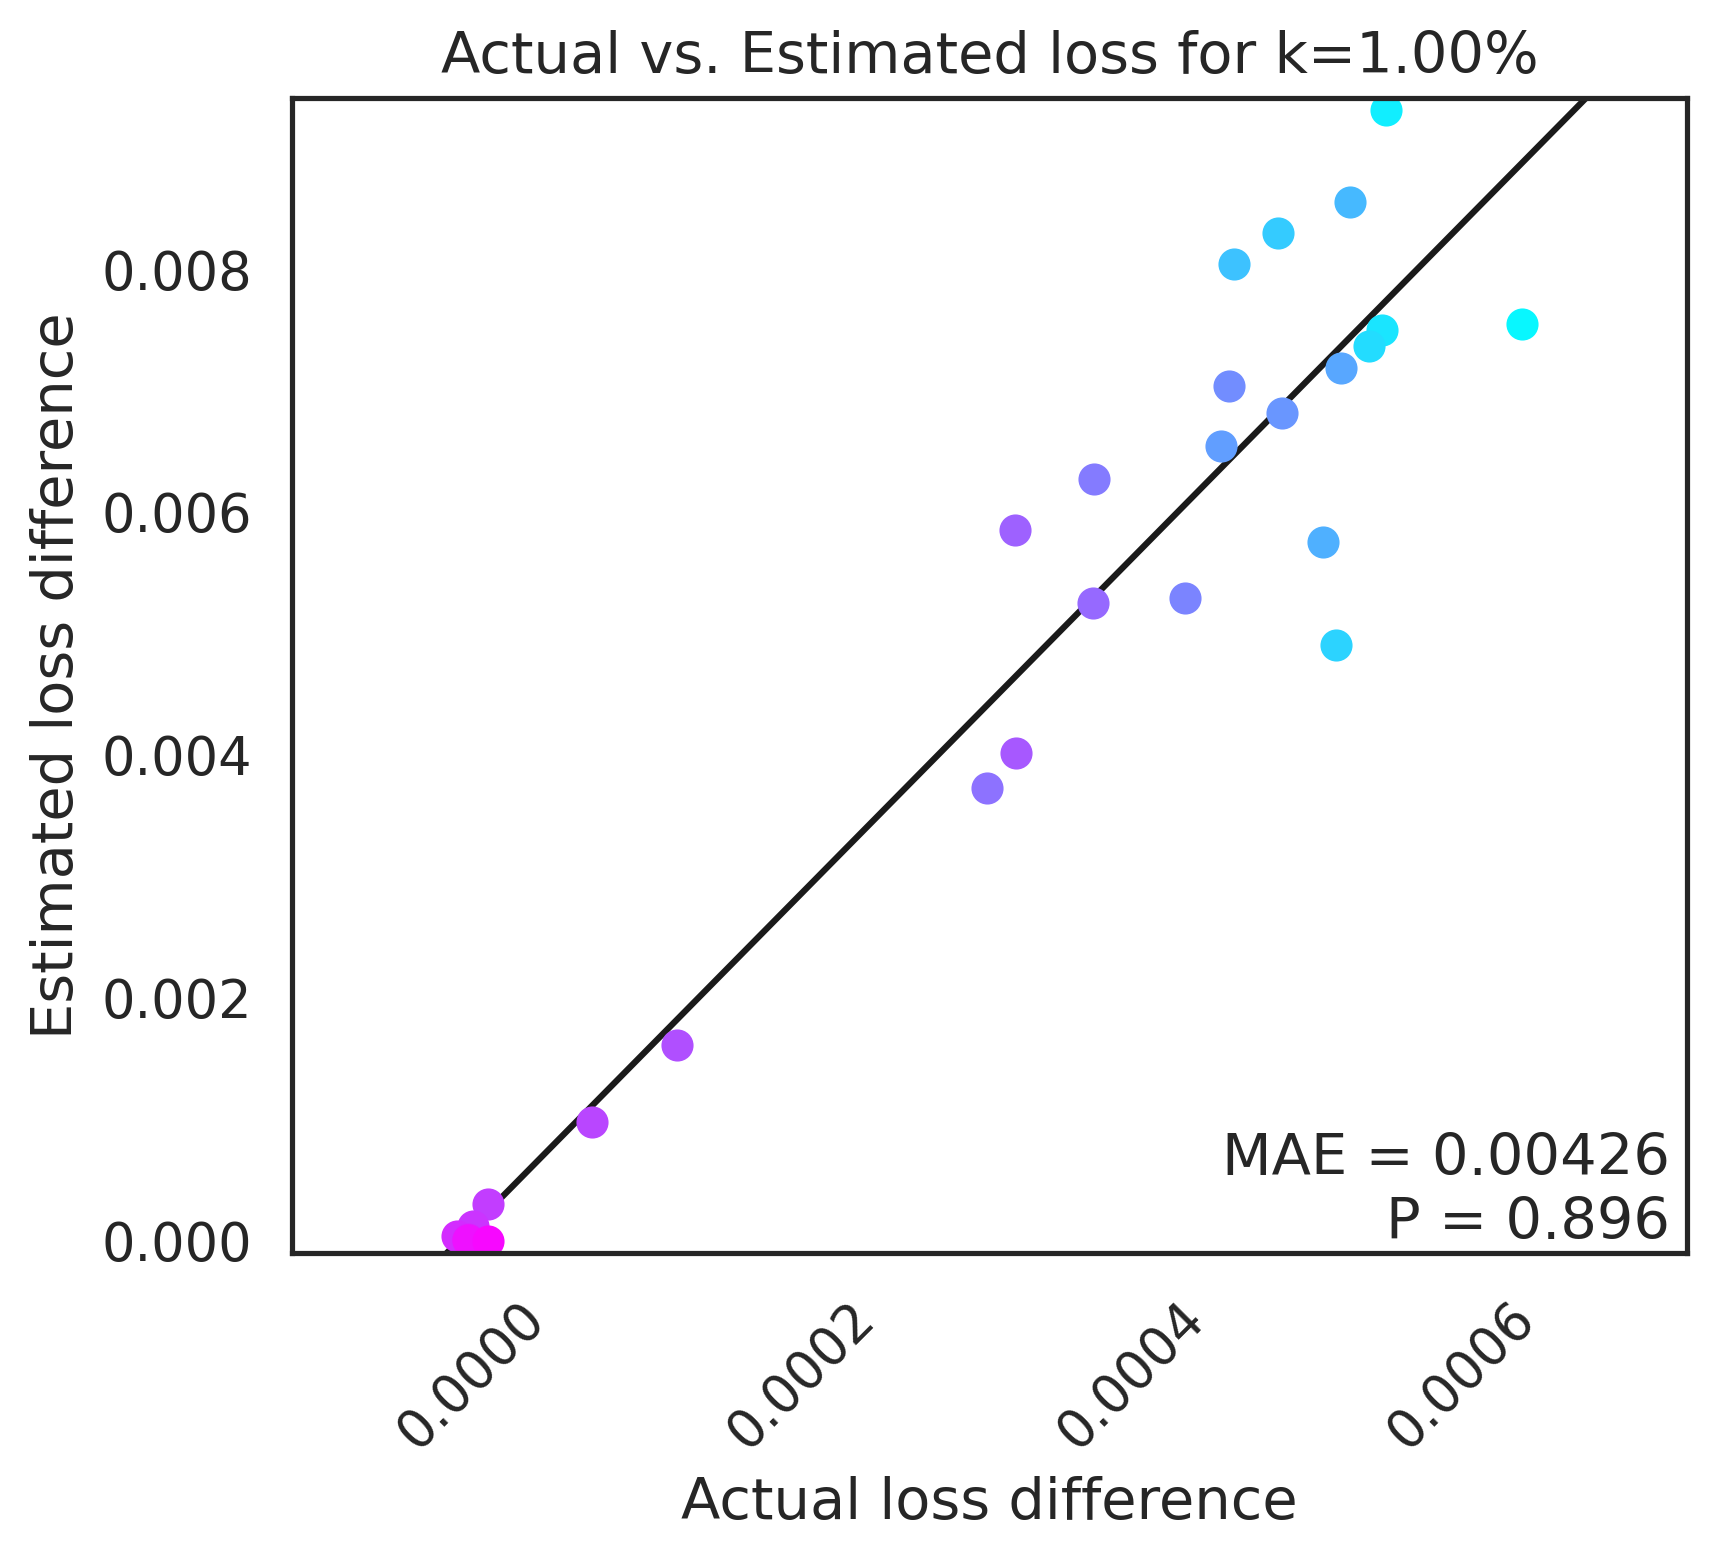

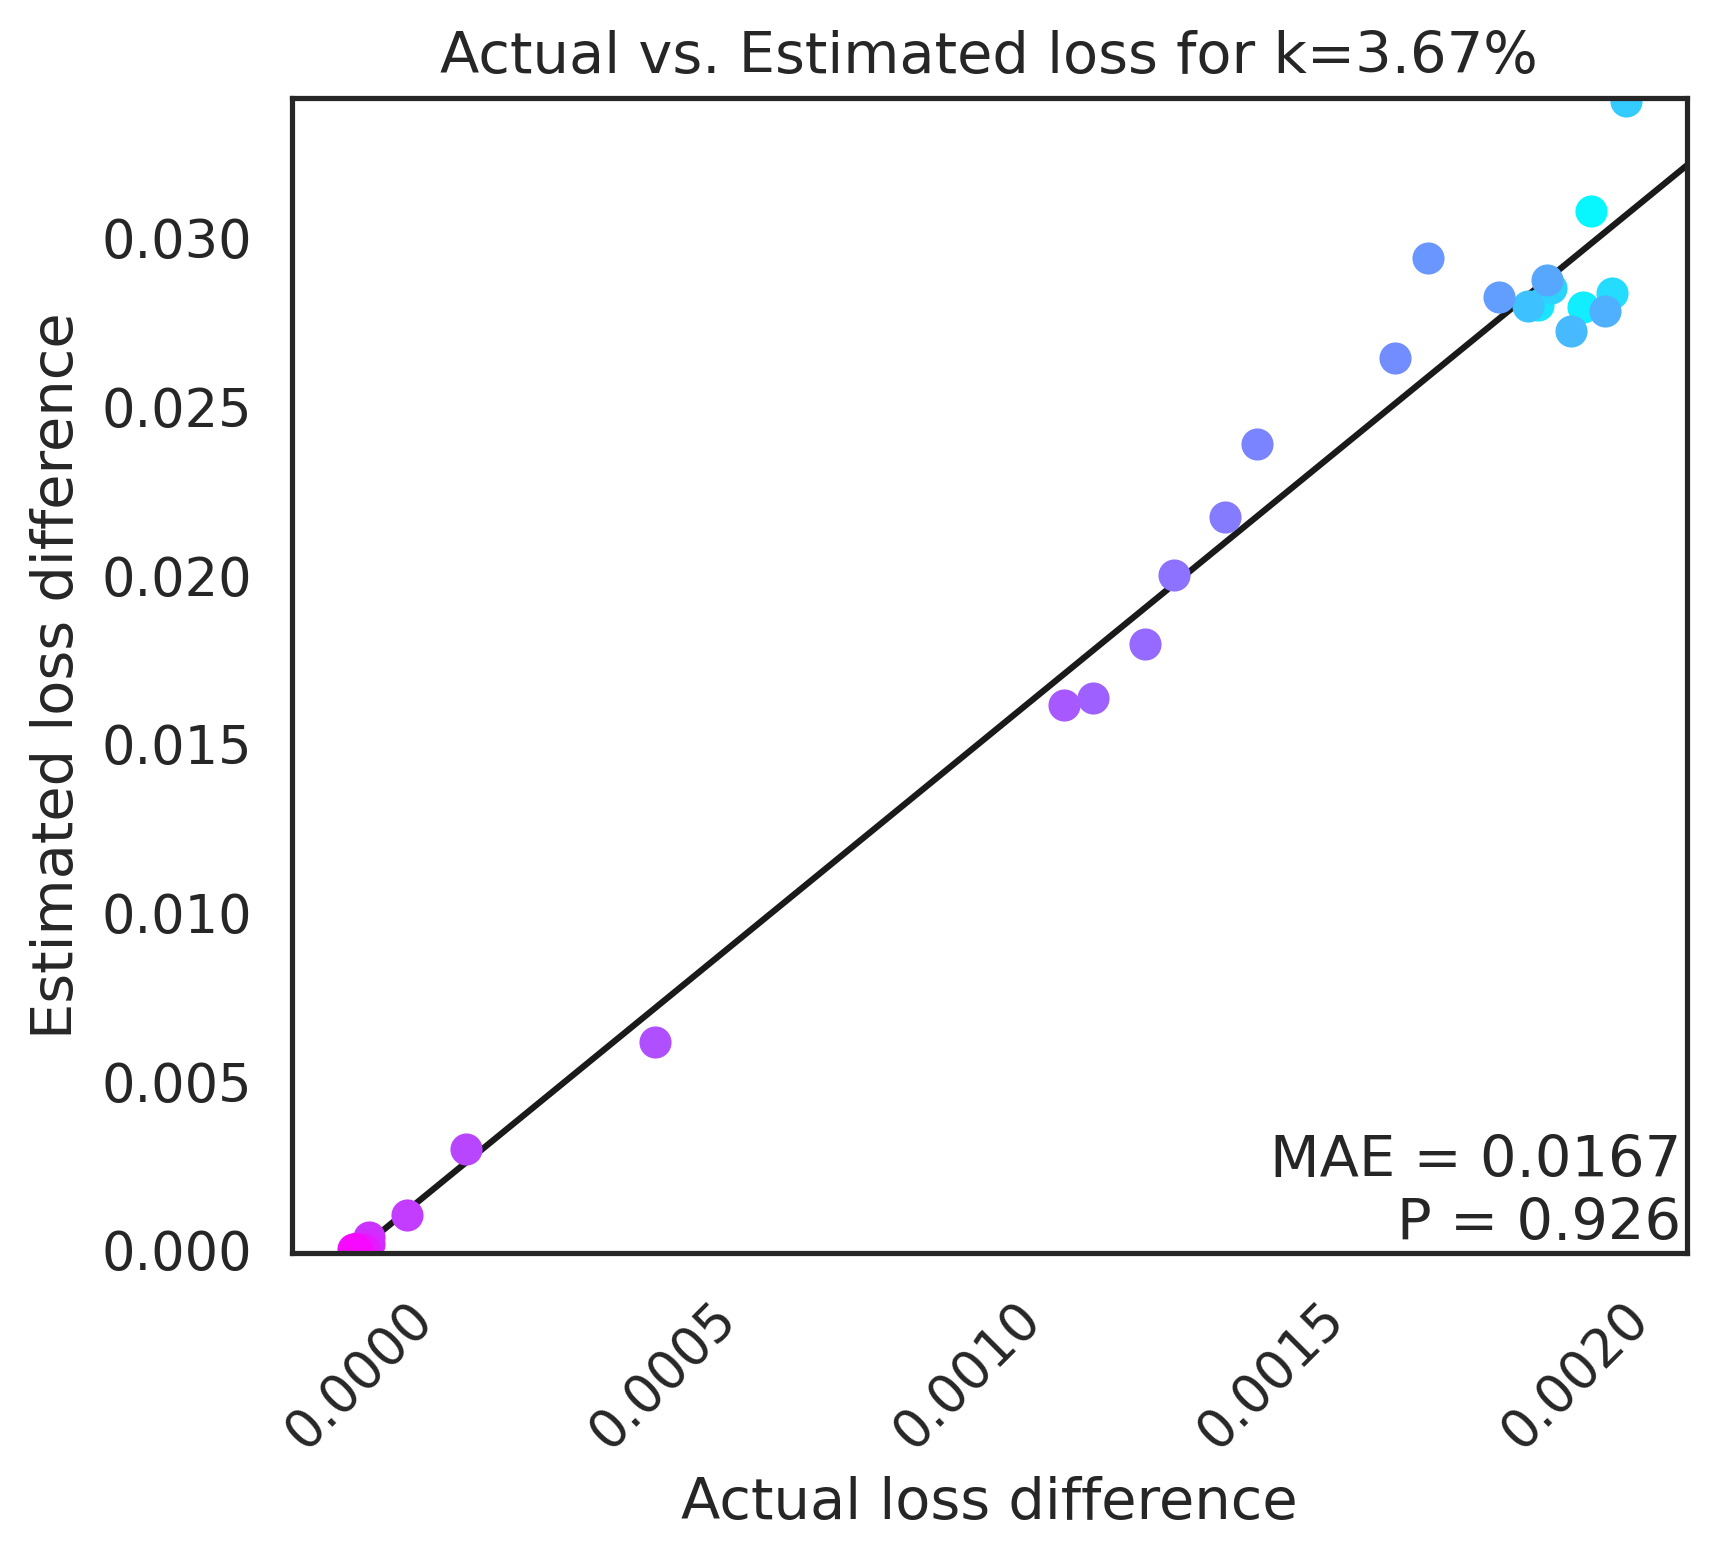

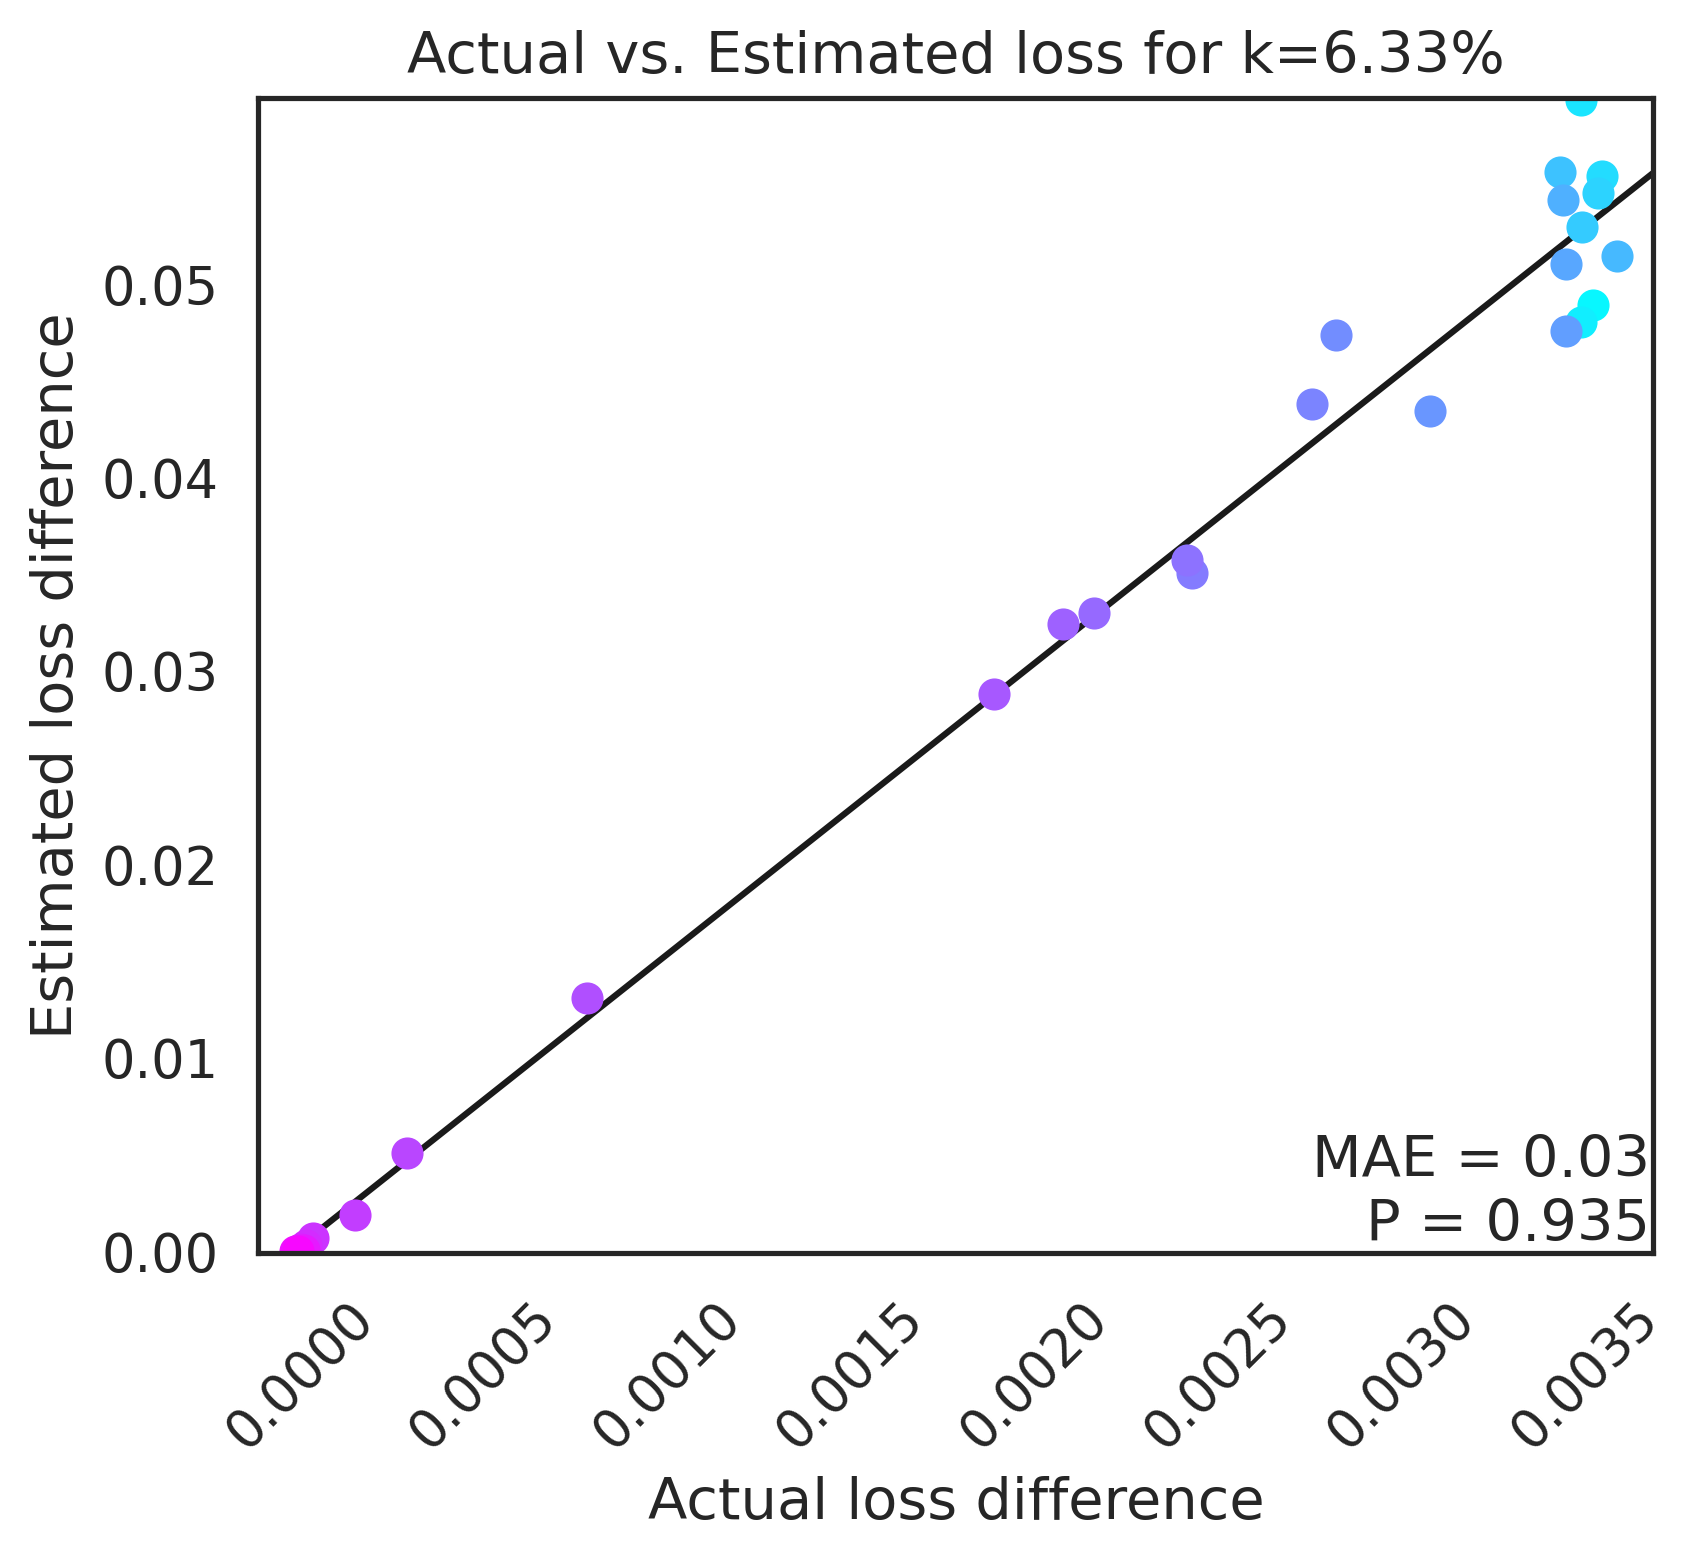

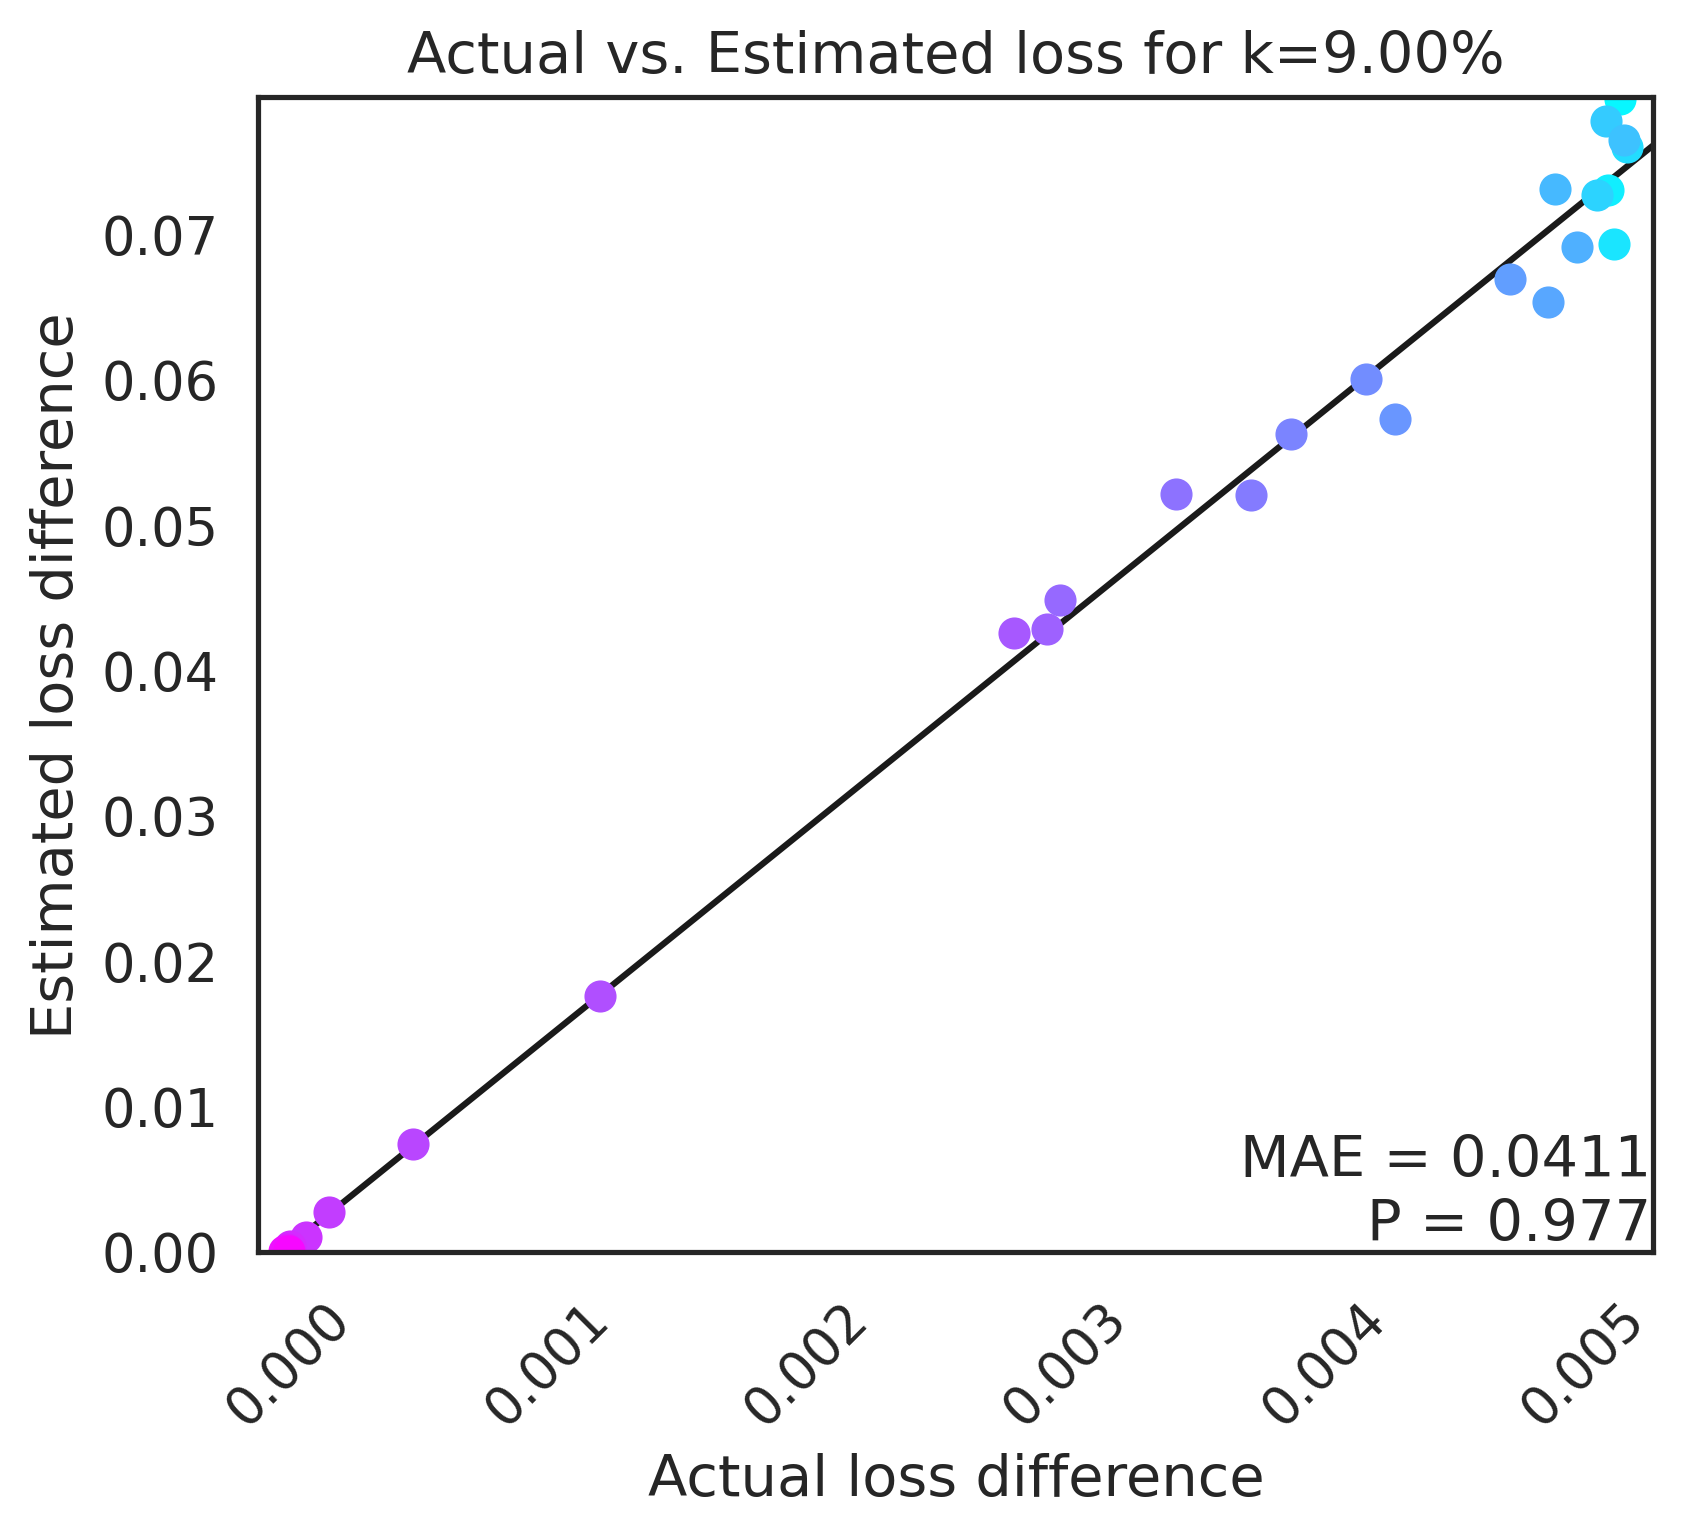

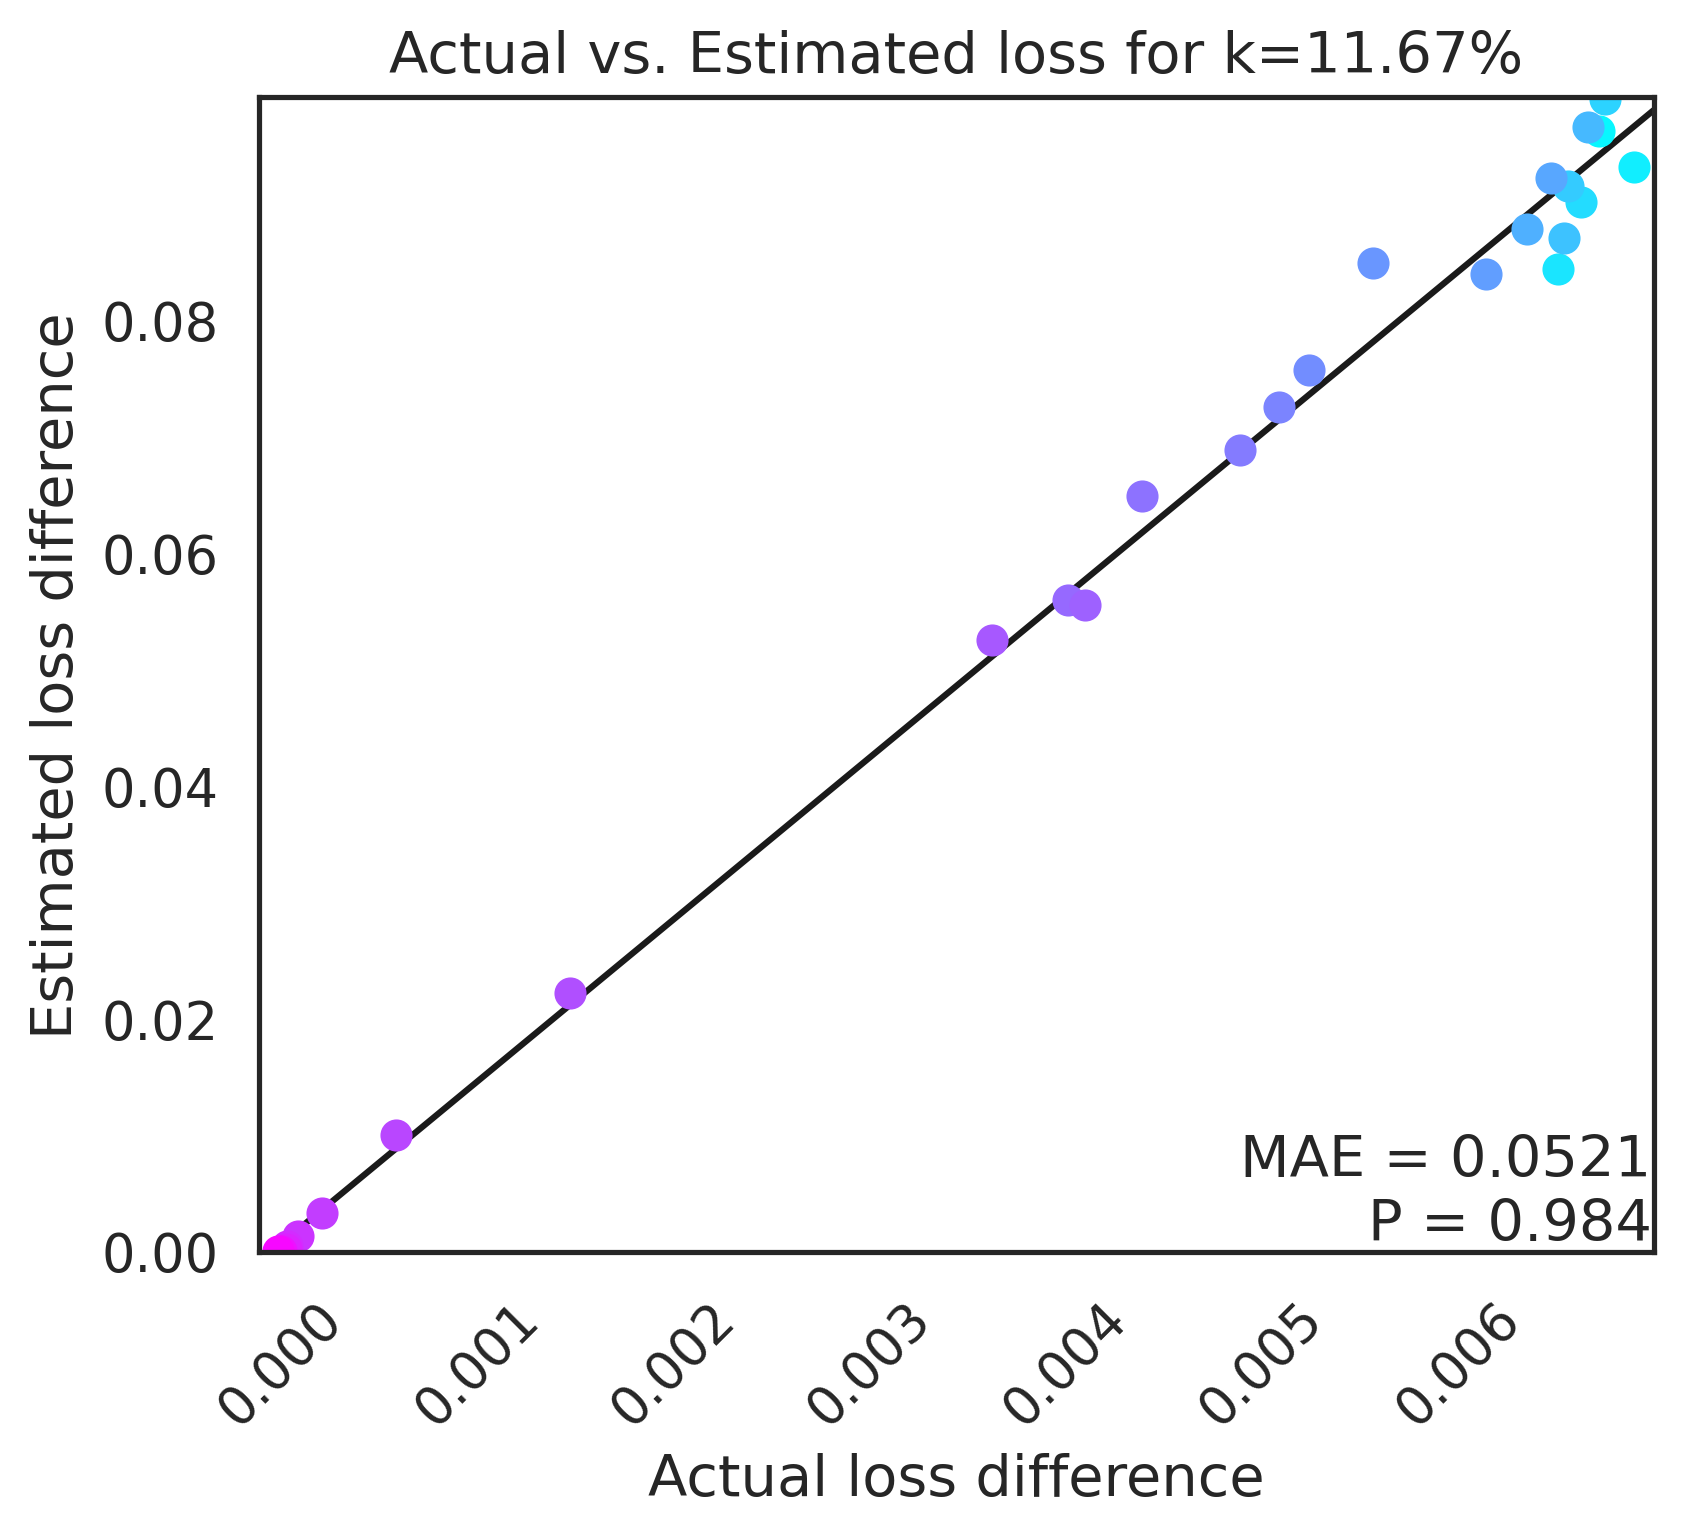

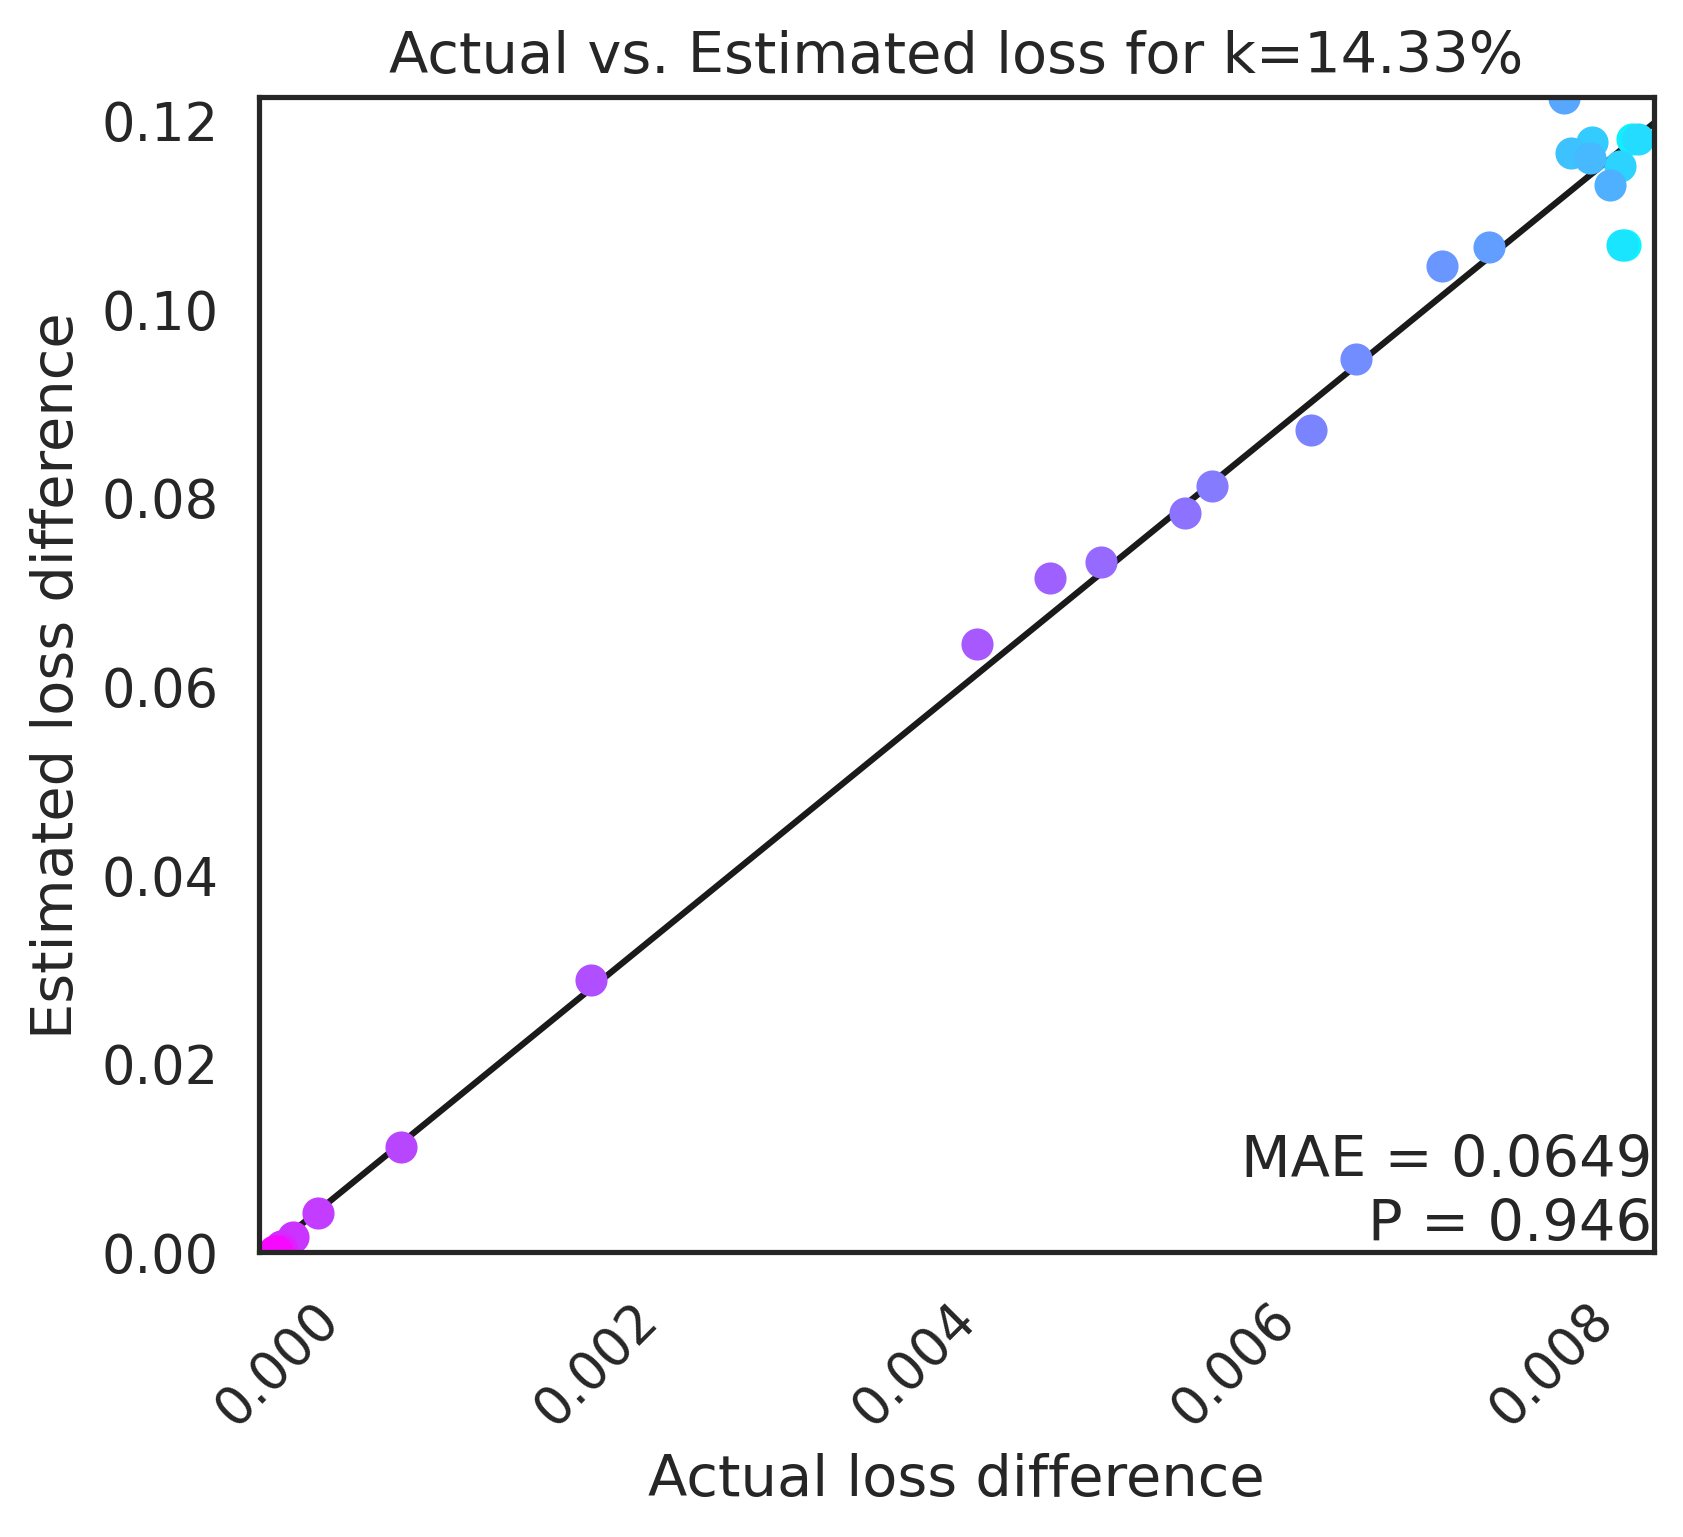

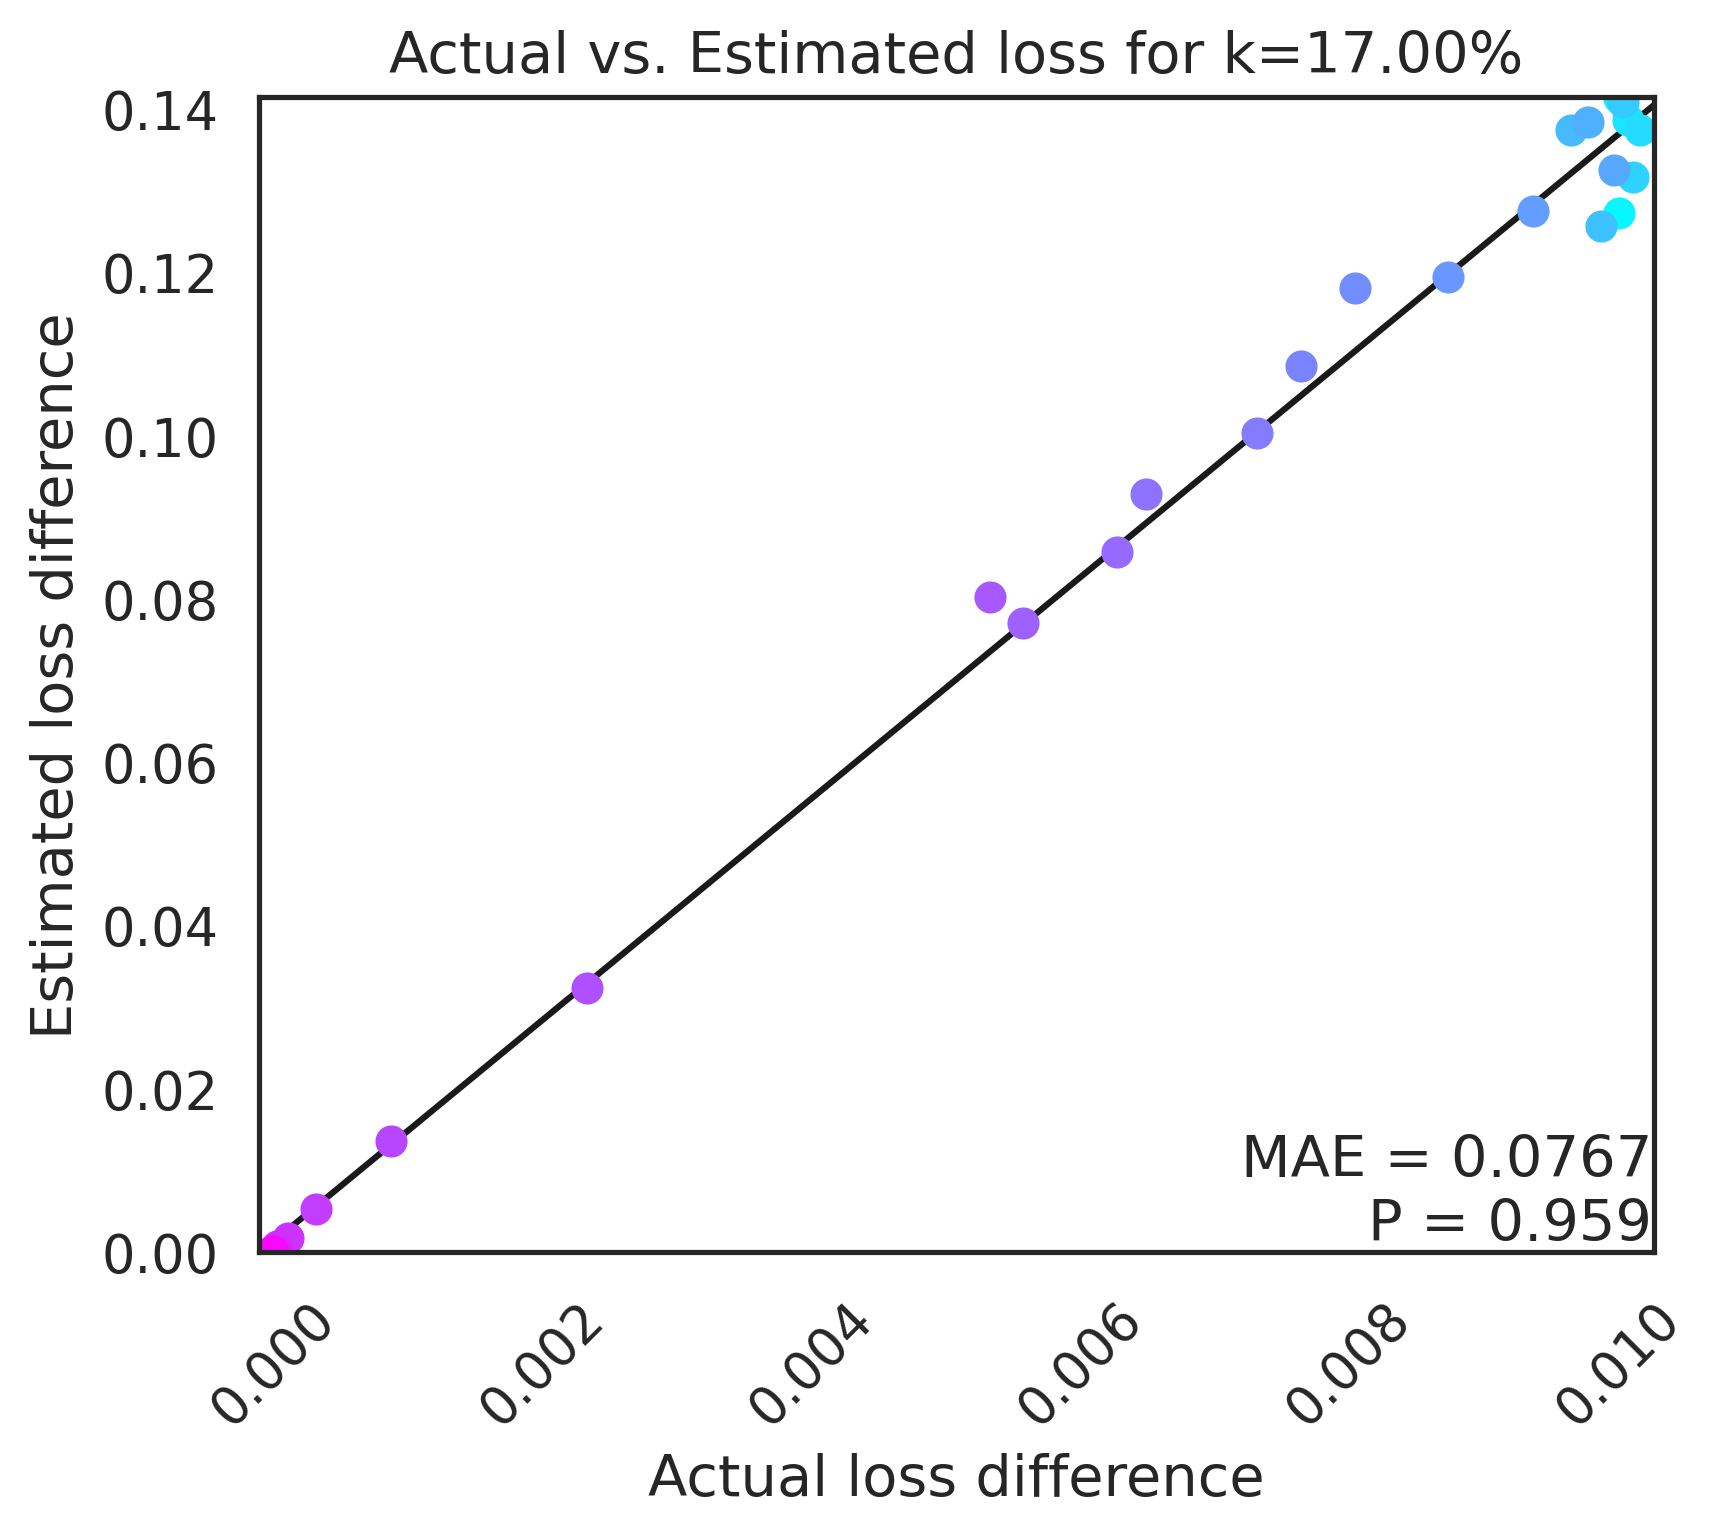

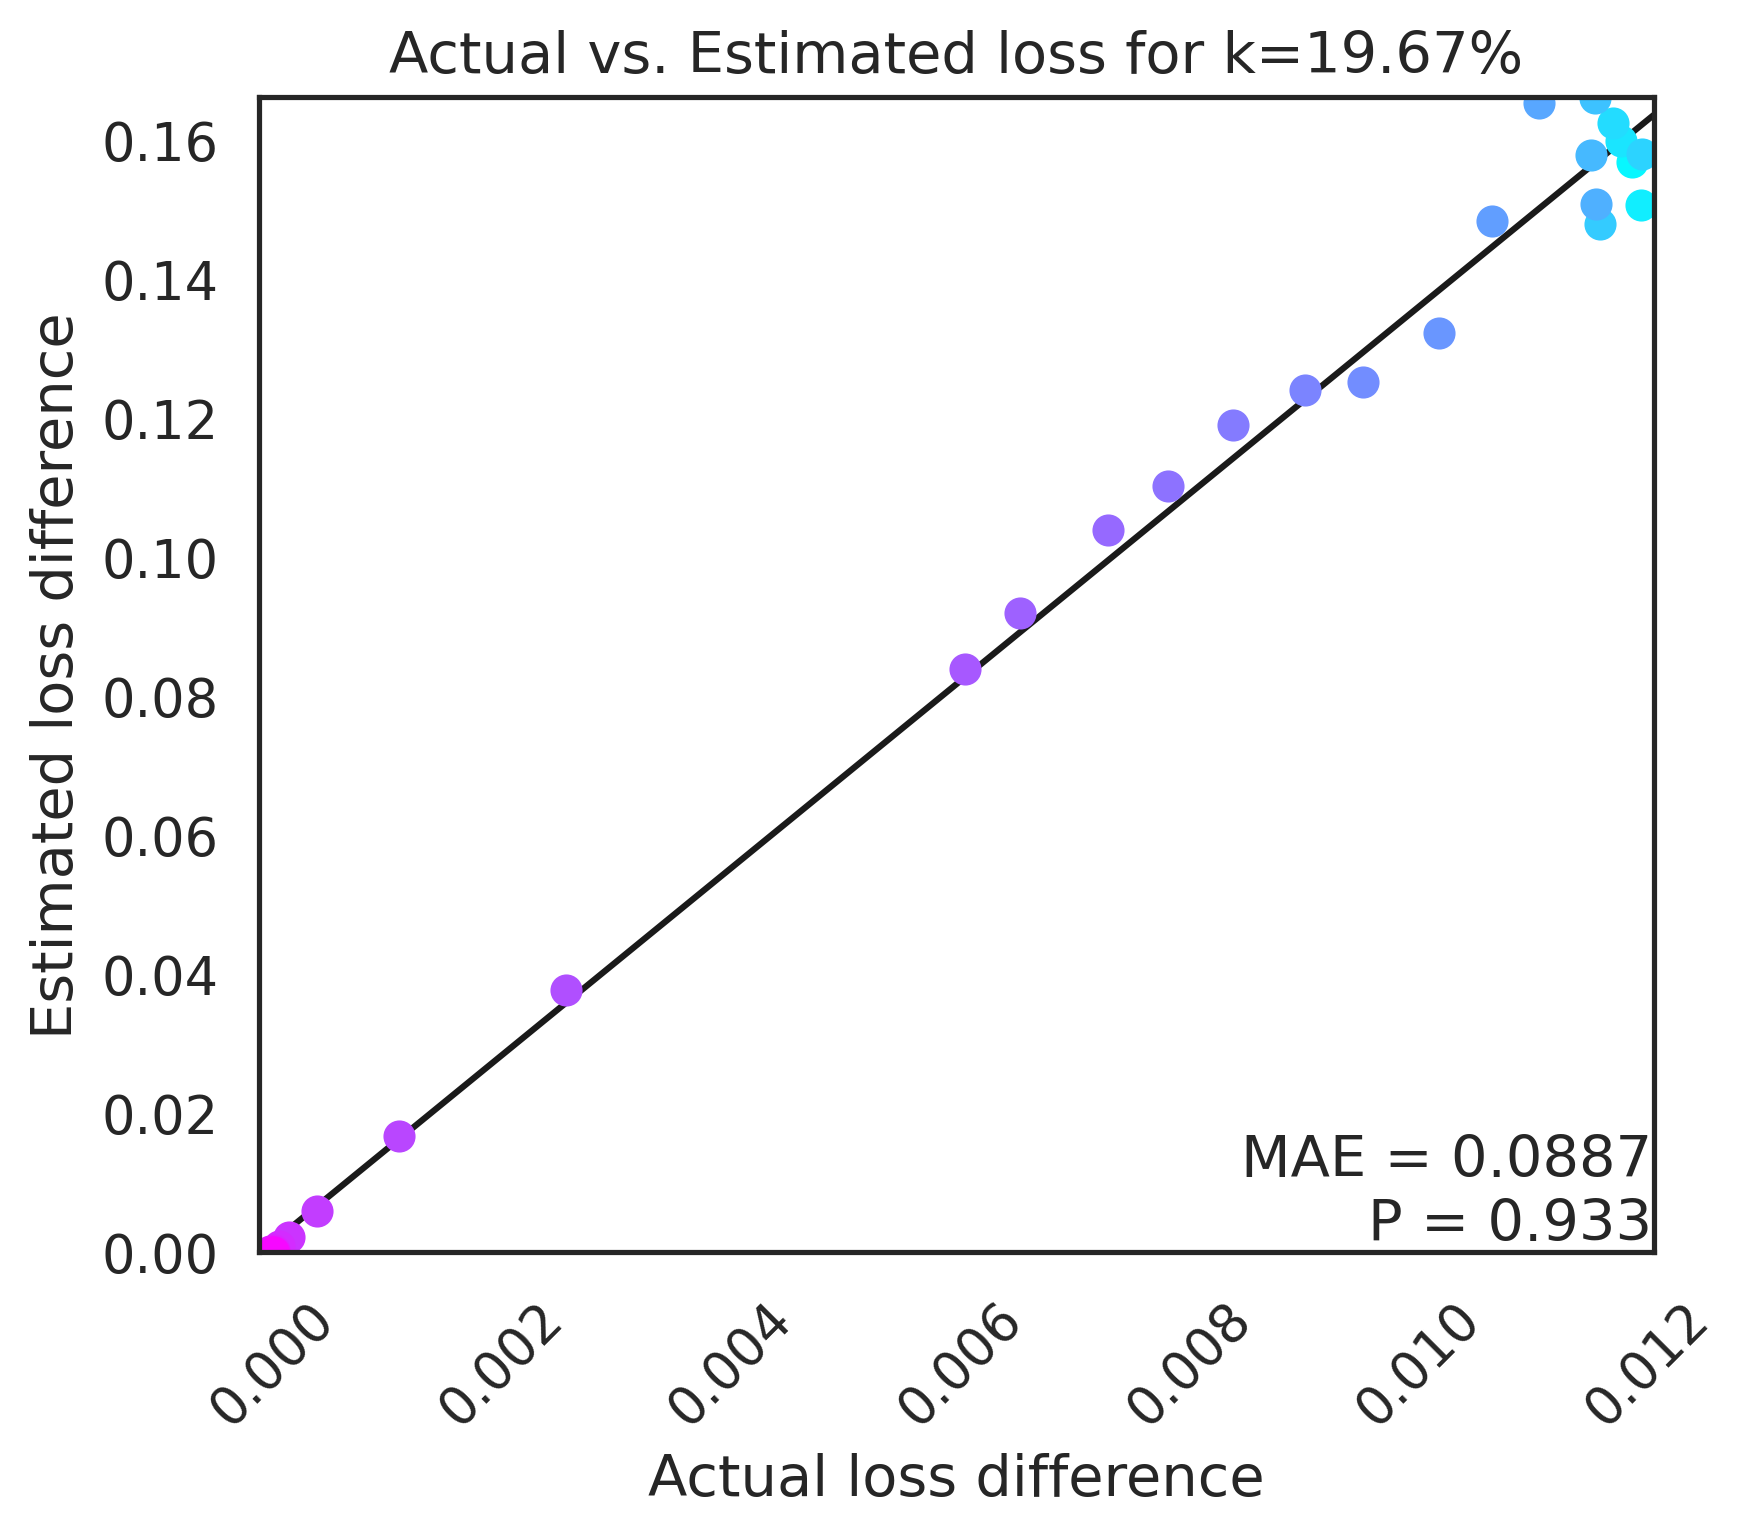

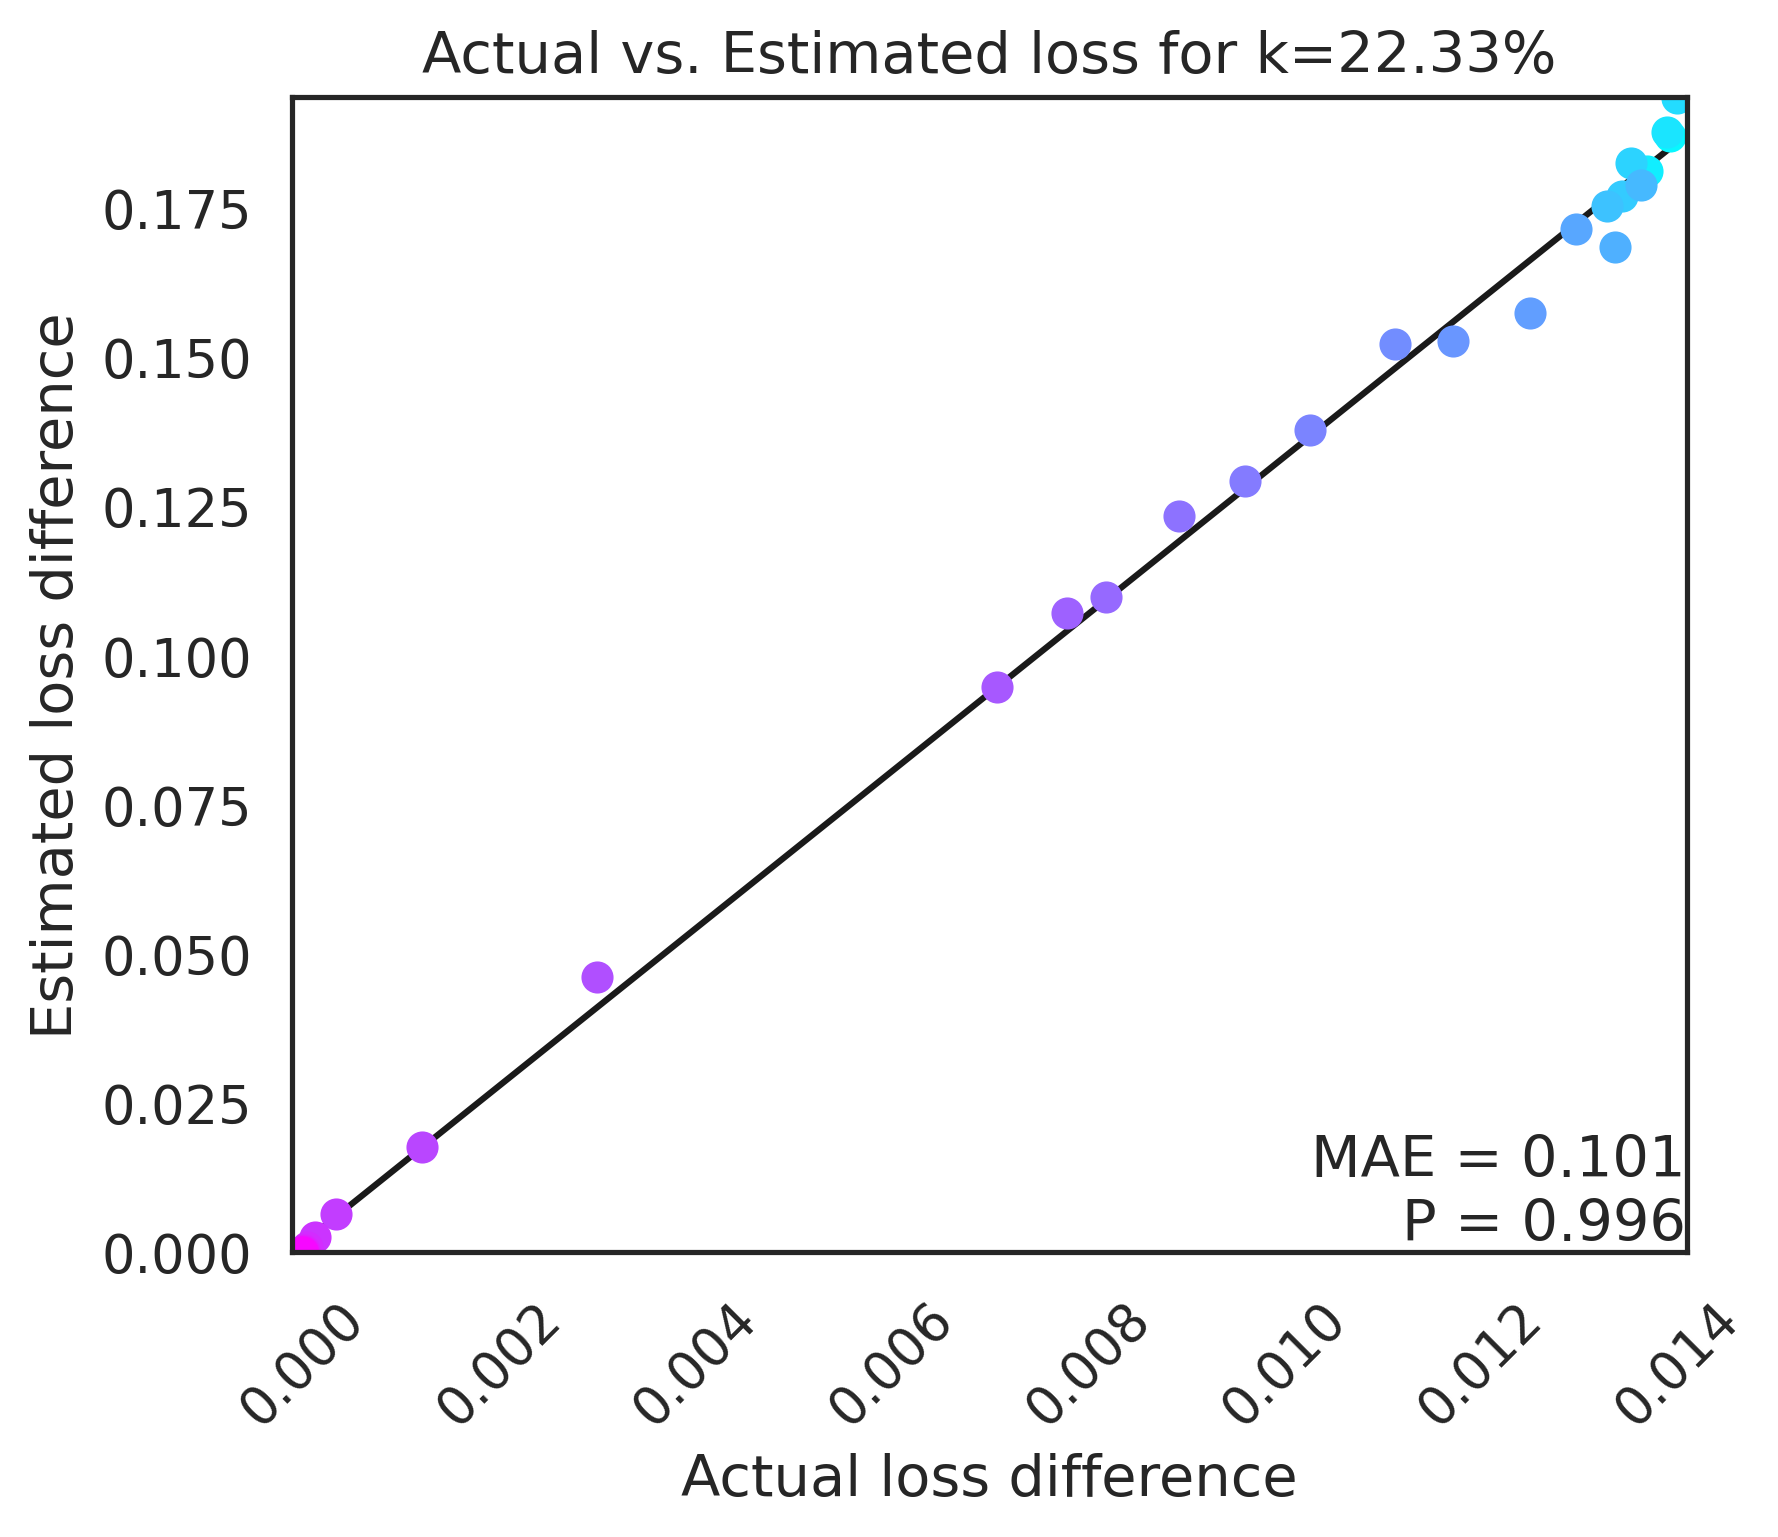

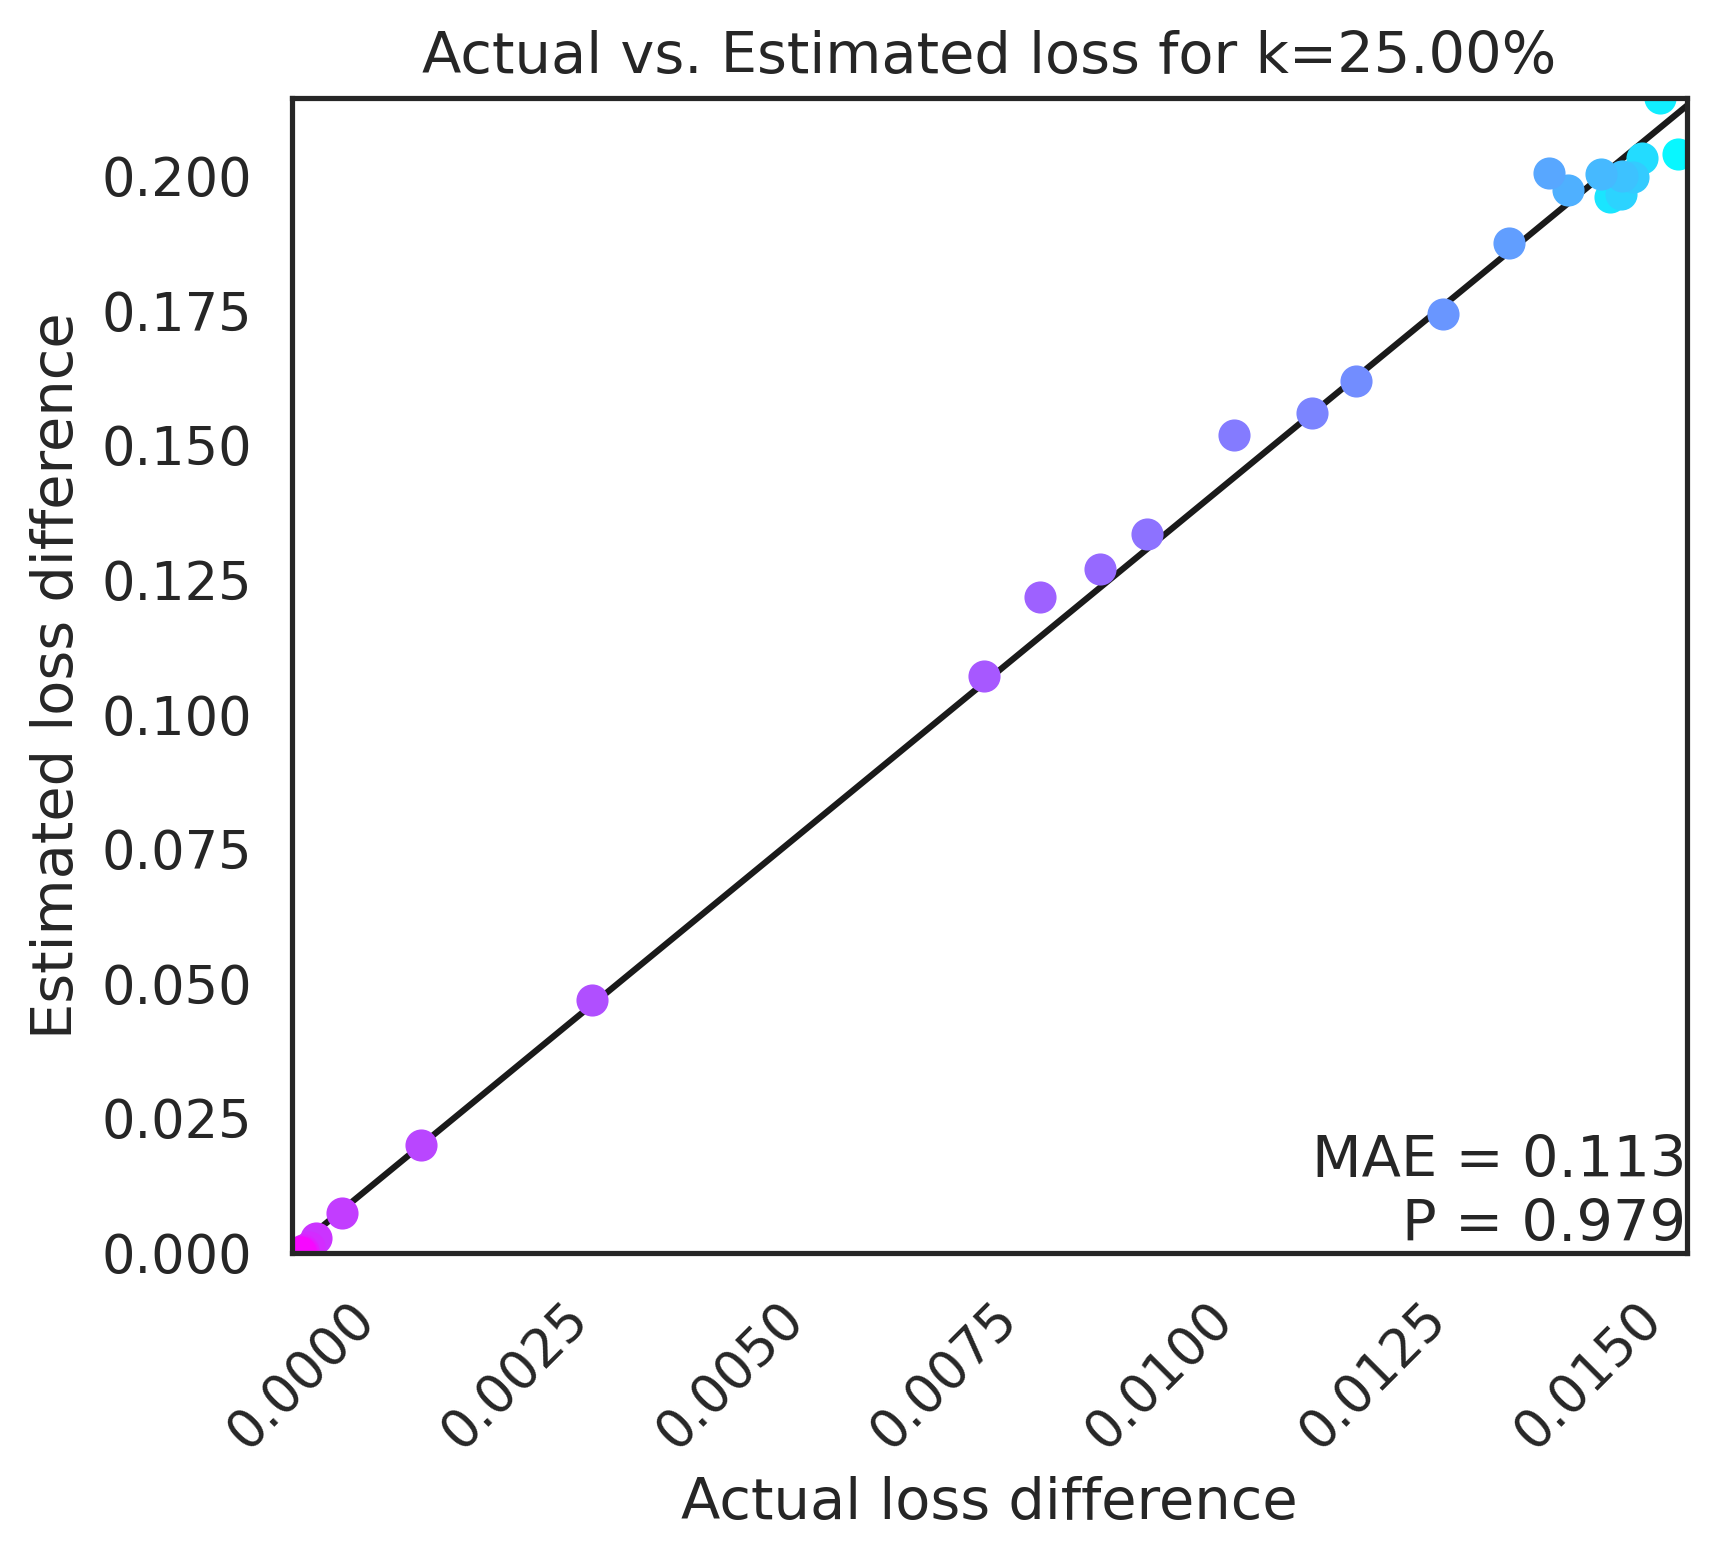

In [20]:
for i in range(len(k_e_orig)):
    visualize_result(k_e_orig[i], k_e_est[i], epsilons, k_[i])

In [21]:
k_e_orig

[[0.0006367067495981852,
  0.0005545914173126221,
  0.0005517303943634033,
  0.0005439817905426025,
  0.0005243221918741862,
  0.000488827625910441,
  0.0004622340202331543,
  0.0005324085553487142,
  0.0005159378051757812,
  0.0005272130171457926,
  0.00045447548230489093,
  0.0004913111527760824,
  0.0004594425360361735,
  0.0004322926203409831,
  0.00037741661071777344,
  0.00031247735023498535,
  0.00037659207979838055,
  0.0003297428290049235,
  0.00033041834831237793,
  0.00012475252151489258,
  7.328391075134277e-05,
  1.0609626770019531e-05,
  1.2715657552083333e-06,
  -8.394320805867514e-06,
  -1.9272168477376303e-06,
  -1.6689300537109375e-06,
  -1.6689300537109375e-06,
  1.053015391031901e-05],
 [0.0020263890425364175,
  0.0020140111446380615,
  0.0019394556681315105,
  0.002061347166697184,
  0.001960982879002889,
  0.00208437442779541,
  0.0019227862358093262,
  0.001994242270787557,
  0.002049992481867472,
  0.001953969399134318,
  0.0018752515316009521,
  0.0017576018969